# **Deep Learning Project: Image Inpainting with Masked Autoencoders**

Students:

-Abbas Yaghi     
-Daniel Hiel     
-Sidra Bilal

In [ ]:
pip install lpips

In [ ]:
pip install torch-fidelity

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms

import lpips
from torch_fidelity import calculate_metrics

import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep Learning Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kXGv0gjfjdY_jvfaBu1RGmfhQ2SC22W0/Deep Learning Project


**Patch Embeddings**

In [3]:
class PatchEmbed(nn.Module):
    """
    Split Image into Patches and embed them.
    Input: (B, C, H, W) -> Output: (B, Num_Patches, Embed_Dim)
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # We use a Conv2d layer to both patchify and embed in one step
        # Kernel size = patch size and stride = patch size ensures non-overlapping patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: [Batch, Channels, Height, Width]
        x = self.proj(x)
        # x shape after proj: [Batch, Embed_Dim, Grid_H, Grid_W]

        # Flatten the spatial dimensions: [Batch, Embed_Dim, Num_Patches]
        x = x.flatten(2)

        # Transpose to get standard Transformer shape: [Batch, Num_Patches, Embed_Dim]
        x = x.transpose(1, 2)
        return x

**The Masking**

In [4]:
def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [Batch, Num_Patches, Embed_Dim]
    """
    N, L, D = x.shape  # Batch, Length (Num_Patches), Dim
    len_keep = int(L * (1 - mask_ratio))

    # 1. Generate random noise for each patch
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # 2. Sort noise to get random indices (shuffle)
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

    # 3. Store indices to restore order later (crucial for Decoder!)
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # 4. Keep the first 'len_keep' indices
    ids_keep = ids_shuffle[:, :len_keep]

    # 5. Gather the visible patches
    # We use torch.gather to pick the patches selected by ids_keep
    # We need to expand ids_keep to match the dimension D
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # 6. Generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # Unshuffle to get the binary mask in the original order (for loss calculation)
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

**Transformer Block: Vision Transformer block (Encoder)**

In [5]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=drop, batch_first=True)

        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        # Attention Block with Residual connection
        # Note: MultiheadAttention returns (attn_output, attn_weights)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP Block with Residual connection
        x = x + self.mlp(self.norm2(x))
        return x

**Positional Embeddings Helper**

In [6]:
# Helper: 2D Sine-Cosine Position Embedding
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

**The Main Class: MaskedAutoencoderViT**

In [7]:
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE Encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Fixed sin-cos embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, drop=0.0) # Using the Block class
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE Decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, drop=0.0)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # predictor
        # --------------------------------------------------------------------------

        self.initialize_weights()

    def initialize_weights(self):
        # Initialization logic (Sin-Cos for pos_embed)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (standard ViT)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # Initialize mask token
        torch.nn.init.normal_(self.mask_token, std=.02)

        # Initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token

        # Unshuffle: This effectively restores the original order
        # We use the ids_restore from random_masking
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))

        # append cls token
        x = torch.cat([x[:, :1, :], x_], dim=1)

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)

        # We calculate MSE loss
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        # We only want loss on masked patches!
        loss = (loss * mask).sum() / mask.sum()  # Mean loss on removed patches
        return loss

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 * 3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

# Data Loader

In [8]:
# Image transforms
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

# Load datasets
train_dataset = datasets.ImageFolder(
    root="Resized/train",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root="Resized/test",
    transform=transform
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Resize Data

In [ ]:
# Resizing code, does not need to be ran again

# Resize data to 244x244, first cropping shortest side to 244 and then centercropping to 244

SRC_DIR = "Data/"
DST_DIR = "Data/Resized/"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

os.makedirs(DST_DIR, exist_ok=True)

def save_resized(split):
    dataset = datasets.ImageFolder(os.path.join(SRC_DIR, split))

    for path, label in tqdm(dataset.samples, desc=f"Saving {split}"):
        class_name = dataset.classes[label]

        src_path = path
        dst_class_dir = os.path.join(DST_DIR, split, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)

        img = Image.open(src_path).convert("RGB")
        img = transform(img)

        dst_path = os.path.join(dst_class_dir, os.path.basename(src_path))
        img.save(dst_path)

for split in ["train", "test"]:
    save_resized(split)


# Model initialisation and training loop

In [9]:
model = MaskedAutoencoderViT(img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm).to(device)

In [ ]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
print_every = 200

def train(epoch):
    model.train()
    total_loss = 0.0

    for batch_idx, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)

        optimizer.zero_grad()

        loss, _, _ = model(imgs, mask_ratio=0.75)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % print_every == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] "
                f"Iter [{batch_idx}/{len(train_loader)}] "
                f"Loss: {loss.item():.4f}"
            )

    avg_loss = total_loss / len(train_loader)
    return avg_loss


In [ ]:
def test():
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            loss, _, _ = model(imgs, mask_ratio=0.75)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:
# Training loop, you can load the checkpoint in the next cell
best_loss = float("inf")
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(epoch)
    train_losses.append(train_loss)
    scheduler.step()
    val_loss = test()
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_loss,
            },
            "best_mae_model.pth"
        )
        print("Saved best MAE model")


# Check Validation Images

In [10]:
# load best model weights from .pth file
checkpoint = torch.load("best_mae_model.pth")

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [11]:
# Get test images for 75% masking ratio
model.eval()
test_images, _ = next(iter(test_loader))
test_images75 = test_images[:8].to(device)

with torch.no_grad():
    loss, pred, mask = model(test_images75, mask_ratio=0.75)

**75% Masking Ratio Images**

In [12]:
inv_pixel = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size**2 * 3)
inv_pixel = model.unpatchify(inv_pixel)
mask_pixel = 1 - inv_pixel

test_masked = test_images75 * mask_pixel

reconstructed = model.unpatchify(pred)
pretty_reconstructed = reconstructed * inv_pixel
pretty_reconstructed += test_masked

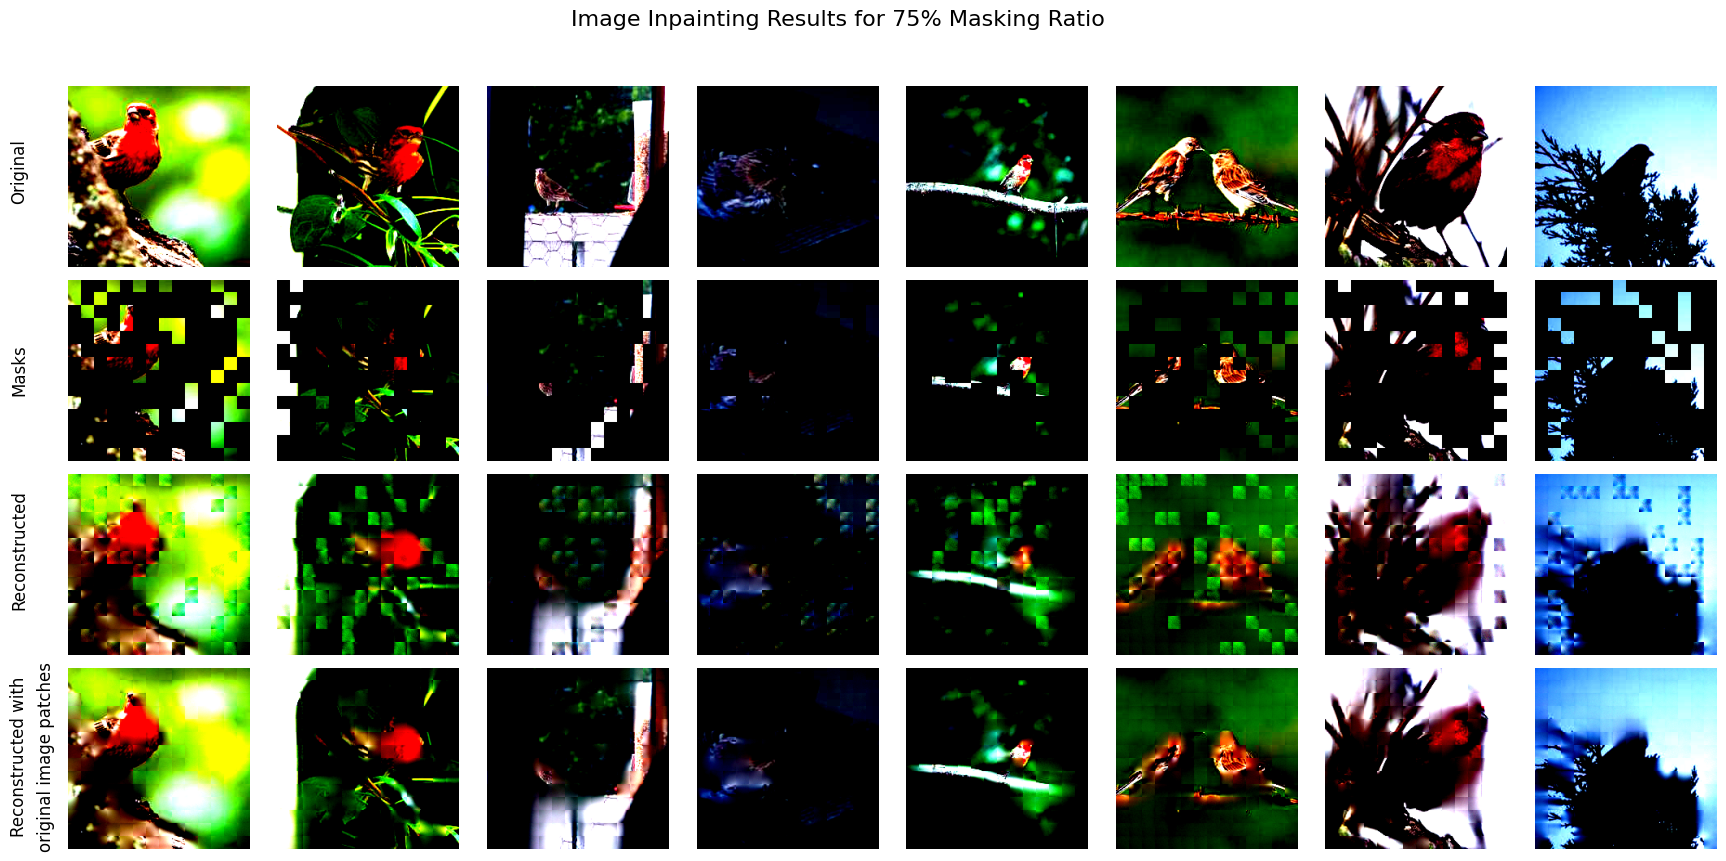

In [22]:
# Move to CPU for visualization
test_images75 = test_images75.cpu()
reconstructed = reconstructed.cpu()
pretty_reconstructed = pretty_reconstructed.cpu()
test_masked = test_masked.cpu()

# Visualize results
fig, axes = plt.subplots(4, 8, figsize=(18, 9))
fig.suptitle('Image Inpainting Results for 75% Masking Ratio', fontsize=16)

for i in range(8):
    axes[0, i].imshow(test_images75[i].permute(1, 2, 0).numpy())
    axes[0, i].axis('off')

    axes[1, i].imshow(test_masked[i].permute(1, 2, 0).numpy())
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed[i].permute(1, 2, 0).numpy())
    axes[2, i].axis('off')

    axes[3, i].imshow(pretty_reconstructed[i].permute(1, 2, 0).numpy())
    axes[3, i].axis('off')

# Row labels (figure-level)
fig.text(0.04, 0.80, 'Original', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.58, 'Masks', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.38, 'Reconstructed', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.15, 'Reconstructed with', va='center', rotation=90, fontsize=12)
fig.text(0.055, 0.15, 'original image patches', va='center', rotation=90, fontsize=12)

plt.tight_layout(rect=[0.06, 0.03, 1, 0.95])
plt.show()


**50% Masking Ratio Images**

In [26]:
# Use different images for 50% masking ratio
test_images50 = test_images[16:32].to(device)

with torch.no_grad():
    loss, pred, mask = model(test_images50, mask_ratio=0.50)

In [28]:
inv_pixel = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size**2 * 3)
inv_pixel = model.unpatchify(inv_pixel)
mask_pixel = 1 - inv_pixel

test_masked = test_images50 * mask_pixel

reconstructed = model.unpatchify(pred)
pretty_reconstructed = reconstructed * inv_pixel
pretty_reconstructed += test_masked

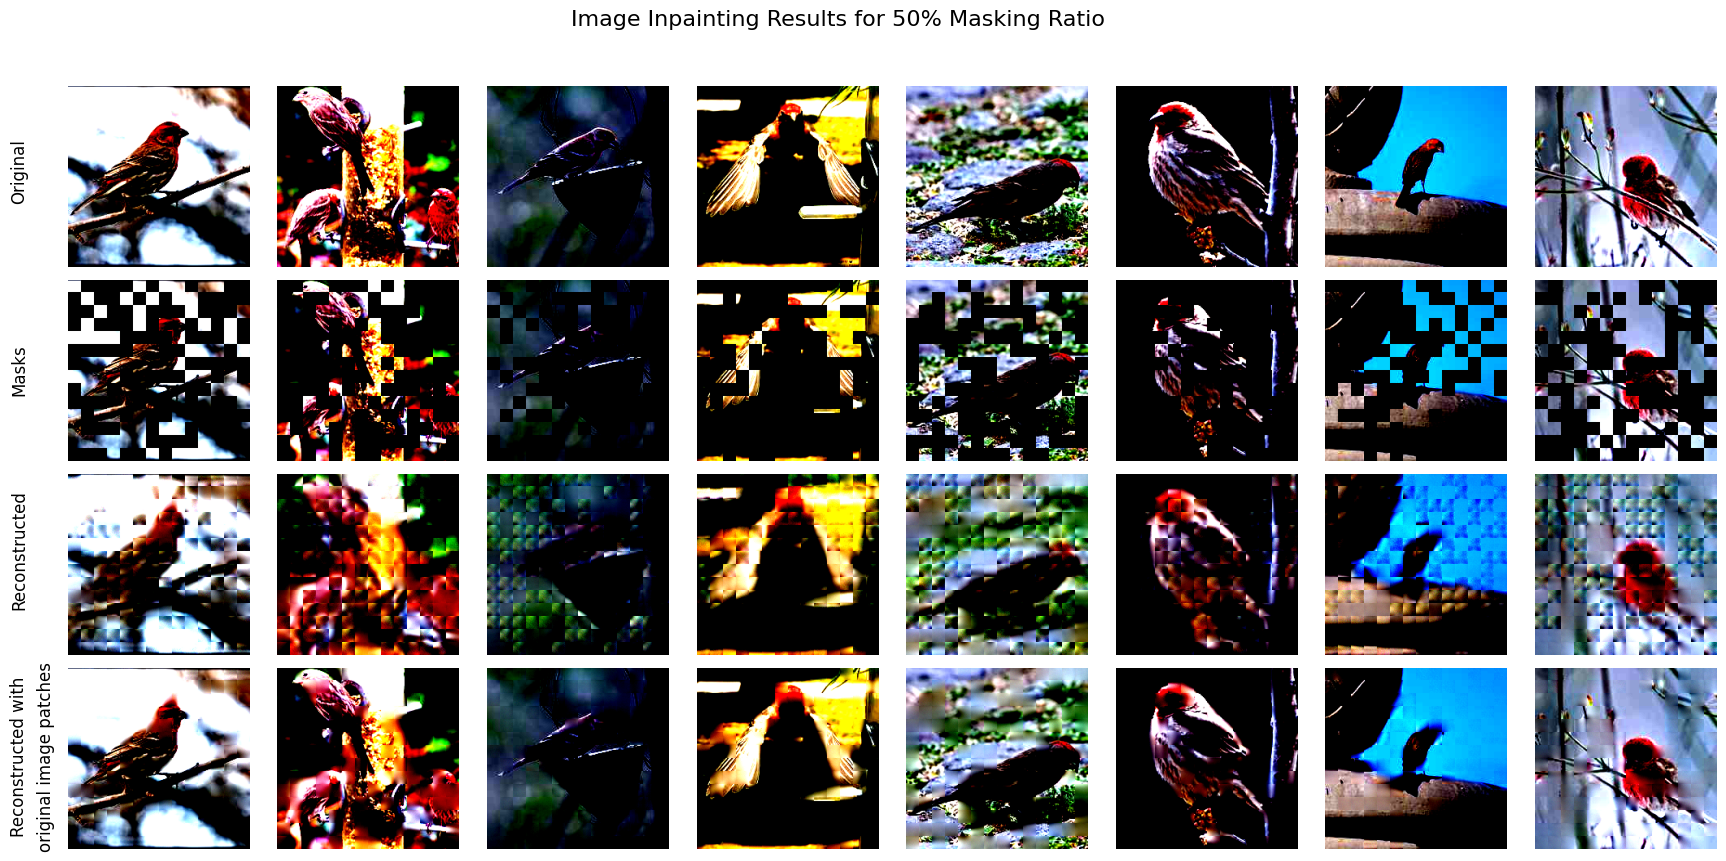

In [29]:
# Move to CPU for visualization
test_images50 = test_images50.cpu()
reconstructed = reconstructed.cpu()
pretty_reconstructed = pretty_reconstructed.cpu()
test_masked = test_masked.cpu()

# Visualize results
fig, axes = plt.subplots(4, 8, figsize=(18, 9))
fig.suptitle('Image Inpainting Results for 50% Masking Ratio', fontsize=16)

for i in range(8):
    axes[0, i].imshow(test_images50[i].permute(1, 2, 0).numpy())
    axes[0, i].axis('off')

    axes[1, i].imshow(test_masked[i].permute(1, 2, 0).numpy())
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed[i].permute(1, 2, 0).numpy())
    axes[2, i].axis('off')

    axes[3, i].imshow(pretty_reconstructed[i].permute(1, 2, 0).numpy())
    axes[3, i].axis('off')

# Row labels (figure-level)
fig.text(0.04, 0.80, 'Original', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.58, 'Masks', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.38, 'Reconstructed', va='center', rotation=90, fontsize=12)
fig.text(0.04, 0.15, 'Reconstructed with', va='center', rotation=90, fontsize=12)
fig.text(0.055, 0.15, 'original image patches', va='center', rotation=90, fontsize=12)

plt.tight_layout(rect=[0.06, 0.03, 1, 0.95])
plt.show()


# Evaluators

**LPIPS**

In [ ]:
lpips_fn = lpips.LPIPS(net='alex').to(device)

In [ ]:
def denormalize(imgs, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(imgs.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(imgs.device)
    return imgs * std + mean

In [ ]:
def to_lpips_range(imgs):
    # imgs assumed in [0,1]
    return imgs * 2.0 - 1.0

**75**%

In [ ]:
# LPIPS with 75% masking ratio

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

lpips_scores = []

print_every = 20

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(test_loader):
        imgs = imgs.to(device)

        # MAE
        loss, pred, mask = model(imgs, mask_ratio=0.75)

        # Reconstructed images
        recon_imgs = model.unpatchify(pred)

        # Denormalize
        imgs_denorm = denormalize(imgs, mean, std)
        recon_denorm = denormalize(recon_imgs, mean, std)

        # Clamp to valid range
        imgs_denorm = imgs_denorm.clamp(0, 1)
        recon_denorm = recon_denorm.clamp(0, 1)

        # Convert to LPIPS range
        imgs_lpips = to_lpips_range(imgs_denorm)
        recon_lpips = to_lpips_range(recon_denorm)

        # Compute LPIPS
        dist = lpips_fn(imgs_lpips, recon_lpips)
        lpips_score = dist.mean().item()
        lpips_scores.append(lpips_score)

        # Print LPIPS score every 200th batch
        if batch_idx % print_every == 0:
            print(
                f"Iter [{batch_idx}/{len(test_loader)}] "
                f"LPIPS: {lpips_score:.4f}"
            )

avg_lpips = sum(lpips_scores) / len(lpips_scores)
print(f"Average LPIPS: {avg_lpips:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iter [0/313] Loss: 0.5951
Iter [20/313] Loss: 0.6261
Iter [40/313] Loss: 0.6019
Iter [60/313] Loss: 0.5810
Iter [80/313] Loss: 0.6436
Iter [100/313] Loss: 0.5879
Iter [120/313] Loss: 0.5819
Iter [140/313] Loss: 0.5742
Iter [160/313] Loss: 0.5836
Iter [180/313] Loss: 0.5919
Iter [200/313] Loss: 0.5327
Iter [220/313] Loss: 0.5347
Iter [240/313] Loss: 0.5727
Iter [260/313] Loss: 0.5888
Iter [280/313] Loss: 0.6213
Iter [300/313] Loss: 0.6058
Average LPIPS: 0.5851


**50**%

In [ ]:
# LPIPS with 50% masking ratio

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

lpips_scores = []

print_every = 20

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(test_loader):
        imgs = imgs.to(device)

        # MAE
        loss, pred, mask = model(imgs, mask_ratio=0.50)

        # Reconstructed images
        recon_imgs = model.unpatchify(pred)

        # Denormalize
        imgs_denorm = denormalize(imgs, mean, std)
        recon_denorm = denormalize(recon_imgs, mean, std)

        # Clamp to valid range
        imgs_denorm = imgs_denorm.clamp(0, 1)
        recon_denorm = recon_denorm.clamp(0, 1)

        # Convert to LPIPS range
        imgs_lpips = to_lpips_range(imgs_denorm)
        recon_lpips = to_lpips_range(recon_denorm)

        # Compute LPIPS
        dist = lpips_fn(imgs_lpips, recon_lpips)
        lpips_score = dist.mean().item()
        lpips_scores.append(lpips_score)

        # Print LPIPS score every 200th batch
        if batch_idx % print_every == 0:
            print(
                f"Iter [{batch_idx}/{len(test_loader)}] "
                f"LPIPS: {lpips_score:.4f}"
            )

avg_lpips = sum(lpips_scores) / len(lpips_scores)
print(f"Average LPIPS: {avg_lpips:.4f}")


Iter [0/313] LPIPS: 0.5697
Iter [20/313] LPIPS: 0.5884
Iter [40/313] LPIPS: 0.5617
Iter [60/313] LPIPS: 0.5529
Iter [80/313] LPIPS: 0.6052
Iter [100/313] LPIPS: 0.5677
Iter [120/313] LPIPS: 0.5592
Iter [140/313] LPIPS: 0.5504
Iter [160/313] LPIPS: 0.5608
Iter [180/313] LPIPS: 0.5912
Iter [200/313] LPIPS: 0.5331
Iter [220/313] LPIPS: 0.5230
Iter [240/313] LPIPS: 0.5405
Iter [260/313] LPIPS: 0.5487
Iter [280/313] LPIPS: 0.5854
Iter [300/313] LPIPS: 0.5850
Average LPIPS: 0.5610


# Frechet Inception Distance (FID)

**Create reconstructed test images and save to drive**

In [ ]:
# FID needs all reconstructed images at the same time, so batch loading won't work.
# We can use folders as input for the metric, but the file structures need to match between original and reconstructed image folders
# So we need to create a new folder with the same class file structure as the original images, for both 75% and 50%

print_every = 20

# Directories
test_dir = Path("Resized/test")          # original test set with class folders
recon_dir_base = Path("Reconstructed")   # base folder for reconstructions
recon_dir_75 = recon_dir_base / "75"
recon_dir_50 = recon_dir_base / "50"

# Create folders
os.makedirs(recon75_dir, exist_ok=True)
os.makedirs(recon50_dir, exist_ok=True)

# Get class names from test dataset

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(str(test_dir), transform=transform)
class_names = test_dataset.classes

# Create class subfolders for both mask ratios
for cls in class_names:
    (recon_dir_75 / cls).mkdir(exist_ok=True)
    (recon_dir_50 / cls).mkdir(exist_ok=True)

# Denormalisation values
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# Save reconstructed images batch-by-batch
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass for 75% masking
        loss_75, pred_75, mask_75 = model(imgs, mask_ratio=0.75)
        recon_75 = model.unpatchify(pred_75)
        recon_75 = denormalize(recon_75, mean, std).clamp(0,1)

        # Forward pass for 50% masking
        loss_50, pred_50, mask_50 = model(imgs, mask_ratio=0.5)
        recon_50 = model.unpatchify(pred_50)
        recon_50 = denormalize(recon_50, mean, std).clamp(0,1)

        if batch_idx % print_every == 0:
            print(
                f"Iter [{batch_idx}/{len(test_loader)}] "
            )

        # Save images in their class folders
        for i in range(imgs.shape[0]):
            cls_name = test_dataset.classes[labels[i].item()]

            # 75% recon
            save_path_75 = recon_dir_75 / cls_name / f"recon_{batch_idx*imgs.shape[0]+i:05d}.png"
            save_image(recon_75[i], save_path_75)

            # 50% recon
            save_path_50 = recon_dir_50 / cls_name / f"recon_{batch_idx*imgs.shape[0]+i:05d}.png"
            save_image(recon_50[i], save_path_50)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iter [0/313] 
Iter [20/313] 
Iter [40/313] 
Iter [60/313] 
Iter [80/313] 
Iter [100/313] 
Iter [120/313] 
Iter [140/313] 
Iter [160/313] 
Iter [180/313] 
Iter [200/313] 
Iter [220/313] 
Iter [240/313] 
Iter [260/313] 
Iter [280/313] 
Iter [300/313] 


**75%**

In [ ]:
# Now we can calculate the FID using the created folders, since it needs the entire dataset at the same time

metrics = calculate_metrics(
    input1="Resized/test",
    input2="Reconstructed/75",
    fid=True,
    cuda=True,
    verbose=True,
    samples_find_deep=True
)


fid_value = metrics["frechet_inception_distance"]
print(f"FID: {fid_value:.2f}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples recursively in "Resized/test" with extensions png,jpg,jpeg
Found 10000 samples, some are lossy-compressed - this may affect metrics
Processing samples
Extracting statistics from input 2
Looking for samples recursively in "Reconstructed/75" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples


FID: 224.78


Frechet Inception Distance: 224.7803567100725


**50%**

In [ ]:
metrics = calculate_metrics(
    input1="Resized/test",
    input2="Reconstructed/50",
    fid=True,
    cuda=True,
    verbose=True,
    samples_find_deep=True
)


fid_value = metrics["frechet_inception_distance"]
print(f"FID: {fid_value:.2f}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples recursively in "Resized/test" with extensions png,jpg,jpeg
Found 10000 samples, some are lossy-compressed - this may affect metrics
Processing samples
Extracting statistics from input 2
Looking for samples recursively in "Reconstructed/50" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples


FID: 198.33


Frechet Inception Distance: 198.32706700944286


# Classification

**Classifier Wrapper**

In [ ]:
class ViTClassifier(nn.Module):
    def __init__(self, encoder, num_classes=100, embed_dim=768):
        super().__init__()
        self.encoder = encoder
        # We use the passed embed_dim instead of trying to read it from the encoder
        self.embed_dim = embed_dim

        # Classification Head
        self.head = nn.Linear(self.embed_dim, num_classes)

        # Weight initialization
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # 1. Run Encoder with NO masking (mask_ratio=0.0)
        # Assumes forward_encoder returns (latent, mask, ids_restore)
        latent, _, _ = self.encoder.forward_encoder(x, mask_ratio=0.0)

        # 2. Extract the CLS token (Index 0)
        # latent shape: [Batch, Num_Patches + 1, Embed_Dim]
        cls_token = latent[:, 0, :]

        # 3. Classification
        logits = self.head(cls_token)
        return logits

**Shared Training Function**

In [ ]:
print_every = 200

def train_and_evaluate(model, train_loader, test_loader, epochs, lr, experiment_name):
    print(f"\n>>> Starting Experiment: {experiment_name}")
    print(f"    Epochs: {epochs} | LR: {lr}")

    # Only optimize parameters that require gradients (handles frozen layers automatically)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.05)
    criterion = nn.CrossEntropyLoss()

    # Schedulers are optional but recommended for Fine-tuning
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {'train_acc': [], 'test_acc': []}

    model.to(device)

    for epoch in range(epochs):
        # --- TRAIN ---
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            if batch_idx % print_every == 0:
                    print(
                        f"Epoch [{epoch+1}/{epochs}] "
                        f"Iter [{batch_idx}/{len(train_loader)}] "
                        f"Loss: {loss.item():.4f}"
                    )

        scheduler.step()
        train_acc = 100 * correct / total
        history['train_acc'].append(train_acc)

        # --- TEST ---
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                _, predicted = torch.max(logits.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = 100 * correct_test / total_test
        history['test_acc'].append(test_acc)

        print(f"    Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.1f}% | Test Acc: {test_acc:.1f}%")

    return history

**Linear Probing**

In [ ]:
# 1. Initialize Architecture
mae_probing = MaskedAutoencoderViT(
    img_size=224, patch_size=16, embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
    mlp_ratio=4., norm_layer=nn.LayerNorm
)

# 2. Load Pre-trained Weights
if os.path.exists("best_mae_model.pth"):
    checkpoint = torch.load("best_mae_model.pth", map_location=device)
    mae_probing.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print("✓ Loaded Pre-trained Weights for Probing")
else:
    print("! WARNING: 'best_mae_model.pth' not found.")

# 3. Wrap & Freeze
model_probing = ViTClassifier(mae_probing, num_classes=100, embed_dim=768)

# Freeze Encoder
for param in model_probing.encoder.parameters():
    param.requires_grad = False

# 4. Run Training
history_probing = train_and_evaluate(
    model_probing, train_loader, test_loader,
    epochs=15, lr=1e-3, experiment_name="Linear Probing (Frozen)"
)

In [ ]:
filename = "model_probing.txt"

with open(filename, "w") as f:
    f.write(f"Experiment: My Experiment\n")
    f.write(f"Epochs: {len(history_probing['train_acc'])}\n\n")

    f.write("Epoch\tTrain Acc\tTest Acc\n")
    for i, (train, test) in enumerate(zip(history_probing['train_acc'], history_probing['test_acc']), 1):
        f.write(f"{i}\t{train:.2f}\t{test:.2f}\n")

print(f"Training history saved to {filename}")

**Fine-Tuning**

In [ ]:
# 1. Initialize Architecture
mae_finetune = MaskedAutoencoderViT(
    img_size=224, patch_size=16, embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
    mlp_ratio=4., norm_layer=nn.LayerNorm
)

# 2. Load Pre-trained Weights
if os.path.exists("best_mae_model.pth"):
    checkpoint = torch.load("best_mae_model.pth", map_location=device)
    mae_finetune.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print("✓ Loaded Pre-trained Weights for Fine-Tuning")

# 3. Wrap & Unfreeze
model_finetune = ViTClassifier(mae_finetune, num_classes=100)

# Unfreeze EVERYTHING
for param in model_finetune.parameters():
    param.requires_grad = True

# 4. Run Training (Low LR is critical here!)
history_finetune = train_and_evaluate(
    model_finetune, train_loader, test_loader,
    epochs=20, lr=1e-4, experiment_name="Fine-Tuning (End-to-End)"
)

In [ ]:
filename = "model_finetune.txt"

with open(filename, "w") as f:
    f.write(f"Experiment: My Experiment\n")
    f.write(f"Epochs: {len(history_finetune['train_acc'])}\n\n")

    f.write("Epoch\tTrain Acc\tTest Acc\n")
    for i, (train, test) in enumerate(zip(history_finetune['train_acc'], history_finetune['test_acc']), 1):
        f.write(f"{i}\t{train:.2f}\t{test:.2f}\n")

print(f"Training history saved to {filename}")

**Supervised Baseline**

In [ ]:
# 1. Initialize Architecture (Random Initialization)
mae_baseline = MaskedAutoencoderViT(
    img_size=224, patch_size=16, embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
    mlp_ratio=4., norm_layer=nn.LayerNorm
)

# 2. Wrap (No Loading!)
model_baseline = ViTClassifier(mae_baseline, num_classes=100)

# 3. Run Training
history_baseline = train_and_evaluate(
    model_baseline, train_loader, test_loader,
    epochs=20, lr=5e-4, experiment_name="Supervised Baseline (From Scratch)"
)



In [ ]:
filename = "model_baseline.txt"

with open(filename, "w") as f:
    f.write(f"Experiment: My Experiment\n")
    f.write(f"Epochs: {len(history_baseline['train_acc'])}\n\n")

    f.write("Epoch\tTrain Acc\tTest Acc\n")
    for i, (train, test) in enumerate(zip(history_baseline['train_acc'], history_baseline['test_acc']), 1):
        f.write(f"{i}\t{train:.2f}\t{test:.2f}\n")

print(f"Training history saved to {filename}")

# Comparison Plot

In [ ]:
df_probing = pd.read_csv(
    "model_probing.txt",
    sep="\t",
    skiprows=3  # skip experiment + epochs + blank line
)

df_baseline = pd.read_csv(
    "model_baseline.txt",
    sep="\t",
    skiprows=3  # skip experiment + epochs + blank line
)

df_finetune = pd.read_csv(
    "model_finetune.txt",
    sep="\t",
    skiprows=3  # skip experiment + epochs + blank line
)

test_acc_probing = df_probing["Test Acc"]
test_acc_baseline = df_baseline["Test Acc"]
test_acc_finetune = df_finetune["Test Acc"]

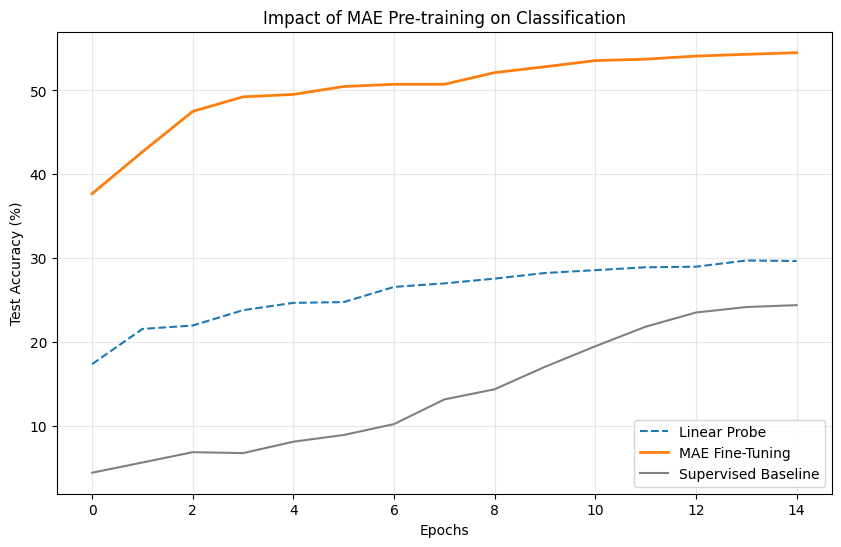

In [ ]:
# --- Final Comparison Plot ---
plt.figure(figsize=(10, 6))
plt.plot(test_acc_probing, label='Linear Probe', linestyle='--')
plt.plot(test_acc_finetune, label='MAE Fine-Tuning', linewidth=2)
plt.plot(test_acc_baseline, label='Supervised Baseline', color='gray')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Impact of MAE Pre-training on Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("mae_comparison_results.png")
plt.show()